In [73]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point
pd.options.display.max_seq_items = 2000

In [74]:
gun_violence_db = pd.read_csv('data/gun_violence_db.csv')
merge_geo=pd.read_csv('data/merge_geo.csv')
counties_db = pd.read_csv('data/counties_db.csv')

In [75]:
#Need to convert counties_db to a geodataframe
counties_db = counties_db.dropna(subset=['geometry'])
counties_db['geometry'] = counties_db['geometry'].apply(wkt.loads)
counties_db = gpd.GeoDataFrame(counties_db, geometry = 'geometry')

## Modélisation

Dans cette partie, nous proposons une tentative de modélisation de la fréquence d'incidents, du nombre de tués et du nombre de blessés au total par an, par comté.

In [76]:
counties_data = counties_db[['fips', 'resident_pop_year_2015','med_h_income_year_2015', 'unemp_rate_year_2015', 'snap_beneficiaries_year_2015', 'bachelors_deg_year_2015', 'bchecks_2015', 'score_legis', 'per_dem']]
counties_data['pop_density'] = counties_db['resident_pop_year_2015']/counties_db['geometry'].area

/tmp/ipykernel_684992/2455505233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_data['pop_density'] = counties_db['resident_pop_year_2015']/counties_db['geometry'].area


In [77]:
counties_data['area'] = counties_db['geometry'].area
states_data = counties_data.groupby('fips').agg({
    'med_h_income_year_2015': 'mean',
    'unemp_rate_year_2015': 'mean',
    'snap_beneficiaries_year_2015': 'mean',
    'bachelors_deg_year_2015': 'mean',
    'bchecks_2015': 'mean',
    'score_legis': 'mean',
    'resident_pop_year_2015': 'mean',
    'area': 'mean',
    'per_dem' : 'mean'
})

states_data['pop_density'] = states_data['resident_pop_year_2015'] / states_data['area']
states_data['bchecks_2015'] = states_data['bchecks_2015'] / states_data['resident_pop_year_2015']

states_data.drop('area', axis=1, inplace=True)


/tmp/ipykernel_684992/443181102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_data['area'] = counties_db['geometry'].area


In [78]:
states_data.head(1)

,med_h_income_year_2015,unemp_rate_year_2015,snap_beneficiaries_year_2015,bachelors_deg_year_2015,bchecks_2015,score_legis,resident_pop_year_2015,per_dem,pop_density
fips,,,,,,,,,
1001.0,56580.0,5.0,8015.0,23.2,13432.945376,2.15,54.903,0.239569,365.396159


In [79]:
incident_data = merge_geo.loc[merge_geo['date'].str.startswith('2015')].groupby('fips').agg({
    'n_killed': 'sum',
    'n_injured': 'sum',
    'incident_id': 'count',
})
incident_data.head(1)

,n_killed,n_injured,incident_id
fips,,,
1001.0,2,4,8


In [80]:
heat_data = pd.merge(left=states_data, right=incident_data, on='fips').drop(columns=['resident_pop_year_2015'])
heat_data.head()

,med_h_income_year_2015,unemp_rate_year_2015,snap_beneficiaries_year_2015,bachelors_deg_year_2015,bchecks_2015,score_legis,per_dem,pop_density,n_killed,n_injured,incident_id
fips,,,,,,,,,,,
1001.0,56580.0,5.0,8015.0,23.2,13432.945376,2.15,0.239569,365.396159,2,4,8
1003.0,52387.0,5.7,22920.0,29.0,3631.242584,2.15,0.195653,495.458372,4,2,13
1005.0,31433.0,8.6,6730.0,12.5,28042.167300,2.15,0.466603,117.802447,1,1,1
1007.0,40767.0,6.7,3794.0,10.6,32701.148406,2.15,0.214220,144.085685,4,1,3
1009.0,50487.0,5.2,7889.0,12.9,12818.440949,2.15,0.084699,349.962621,3,1,3


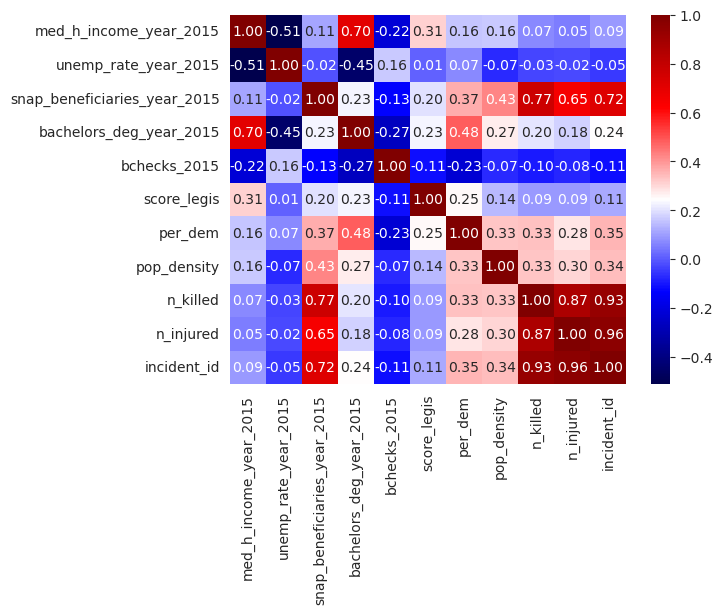

In [81]:
import seaborn as sns
g1 = sns.heatmap(heat_data.corr(), cmap='seismic', annot=True, fmt=".2f")

In [82]:
#COMMENTAIRE DE HEATMAP A INSERER

In [83]:
import statsmodels.api as sm
import pandas as pd

heat_data = heat_data.dropna()

# Add a constant term for the intercept
X = sm.add_constant(heat_data[['med_h_income_year_2015', 'unemp_rate_year_2015',
       'snap_beneficiaries_year_2015', 'bachelors_deg_year_2015',
       'bchecks_2015', 'score_legis',
        'pop_density']])

# Fit the model
model1 = sm.OLS(heat_data['n_killed'], X).fit(cov_type='HC3')

In [84]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               n_killed   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     39.55
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           1.45e-52
Time:                        21:06:36   Log-Likelihood:                -9023.8
No. Observations:                2157   AIC:                         1.806e+04
Df Residuals:                    2149   BIC:                         1.811e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [98]:
print('Avec un R2 de 0.601, le modèle est relativement satisfaisant pour expliquer la variance du nombre de morts par comtés à cause de la violence par armes à feu.')
print("Comme on pouvait s'y attendre, le coefficient apposé au score de législation est négatif, autrement dit la restriction légale des armes à feu diminue le nombre de morts dans chaque comté.")

Avec un R2 de 0.601, le modèle est relativement satisfaisant pour expliquer la variance du nombre de morts par comtés à cause de la violence par armes à feu.
Comme on pouvait s'y attendre, le coefficient apposé au score de législation est négatif, autrement dit la restriction légale des armes à feu diminue le nombre de morts dans chaque comté.


In [86]:
heat_data = heat_data.dropna()

# Add a constant term for the intercept
X = sm.add_constant(heat_data[['med_h_income_year_2015', 'unemp_rate_year_2015',
       'snap_beneficiaries_year_2015', 'bachelors_deg_year_2015',
       'bchecks_2015', 'score_legis',
       'pop_density']])

# Fit the model
model2 = sm.OLS(heat_data['n_injured'], X).fit(cov_type='HC3')

# Print the summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              n_injured   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     23.40
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           8.37e-31
Time:                        21:06:37   Log-Likelihood:                -11632.
No. Observations:                2157   AIC:                         2.328e+04
Df Residuals:                    2149   BIC:                         2.332e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [87]:
heat_data = heat_data.dropna()

# Add a constant term for the intercept
X = sm.add_constant(heat_data[['med_h_income_year_2015', 'unemp_rate_year_2015',
       'snap_beneficiaries_year_2015', 'bachelors_deg_year_2015',
       'bchecks_2015', 'score_legis',
       'pop_density']])

# Fit the model
model3 = sm.OLS(heat_data['incident_id'], X).fit(cov_type='HC3')

# Print the summary
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:            incident_id   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     54.87
Date:                Sat, 30 Dec 2023   Prob (F-statistic):           1.91e-72
Time:                        21:06:37   Log-Likelihood:                -12017.
No. Observations:                2157   AIC:                         2.405e+04
Df Residuals:                    2149   BIC:                         2.410e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [88]:
#COMMENTAIRE A INSERER

Lasso pour confirmer la bonne régression

In [89]:
from sklearn.pipeline import Pipeline

def extract_features_selected(lasso: Pipeline, preprocessing_step_name: str = 'preprocess') -> pd.Series:
    """
    Extracts selected features based on the coefficients obtained from Lasso regression.

    Parameters:
    - lasso (Pipeline): The scikit-learn pipeline containing a trained Lasso regression model.
    - preprocessing_step_name (str): The name of the preprocessing step in the pipeline. Default is 'preprocess'.

    Returns:
    - pd.Series: A Pandas Series containing selected features with non-zero coefficients.
    """
    # Check if lasso object is provided
    if not isinstance(lasso, Pipeline):
        raise ValueError("The provided lasso object is not a scikit-learn pipeline.")

    # Extract the final transformer from the pipeline
    lasso_model = lasso[-1]

    # Check if lasso_model is a Lasso regression model
    if not isinstance(lasso_model, Lasso):
        raise ValueError("The final step of the pipeline is not a Lasso regression model.")

    # Check if lasso model has 'coef_' attribute
    if not hasattr(lasso_model, 'coef_'):
        raise ValueError("The provided Lasso regression model does not have 'coef_' attribute. "
                         "Make sure it is a trained Lasso regression model.")

    # Get feature names from the preprocessing step
    features_preprocessing = lasso[preprocessing_step_name].get_feature_names_out()

    # Extract selected features based on non-zero coefficients
    features_selec = pd.Series(features_preprocessing[np.abs(lasso_model.coef_) > 0])

    return features_selec

In [90]:
from sklearn.model_selection import train_test_split
#2. Echantillon d'entraînement et échantillon test
X_train, X_test, y_train, y_test = train_test_split(
    heat_data.drop(["n_killed", 'n_injured'], axis = 1),
    100*heat_data[['n_killed']], test_size=0.2, random_state=0
)

In [91]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import Lasso

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()


numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [92]:
model = Lasso(fit_intercept=True, alpha = 1)  

lasso_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', model)
])
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['med_h_income_year_2015',
                                                   'unemp_rate_year_2015',
                                                   'snap_beneficiaries_year_2015',
                                                   'bachelors_deg_year_2015',
                                                   'bchecks_2015',
                                                   'score_legis', 'per_dem',
                                                   'pop_density',
                                                   'incident_id']),
                                                 ('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [])])),
                ('model', Lasso(alpha=1))])

In [93]:
# Question 5
lasso1 = lasso_pipeline['model']
features_selec = extract_features_selected(lasso_pipeline)
#np.abs(lasso1.coef_)

In [94]:
features_selec.str.replace("(number__|category__)", "", regex = True)

0          med_h_income_year_2015
1            unemp_rate_year_2015
2    snap_beneficiaries_year_2015
3         bachelors_deg_year_2015
4                    bchecks_2015
5                     score_legis
6                         per_dem
7                     pop_density
8                     incident_id
dtype: object

In [95]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
from sklearn.linear_model import lasso_path

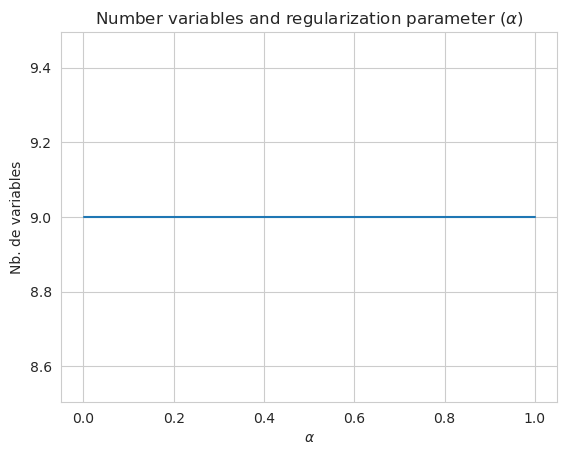

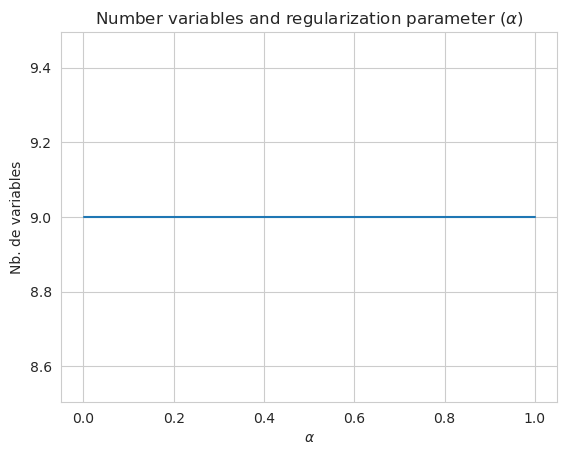

In [96]:
#6. Utilisation de lasso_path
preprocessed_features = pd.DataFrame(
      numeric_pipeline.fit_transform(
        X_train.drop(columns = categorical_features)
      )
  )
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

alpha_for_path, coefs_lasso, _ = lasso_path(
  preprocessed_features,
  y_train,
  alphas=my_alphas)
#print(coefs_lasso)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
nb_non_zero = pd.DataFrame(
  nb_non_zero
).sum(axis = 0)

## graphique

sns.set_style("whitegrid")
plt.figure()
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path)
p.set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')
p.figure.get_figure()